**IMPORT LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import json
import re
import ast
import nltk
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors


**LOAD THE DATA**

In [2]:
movies_df = pd.read_csv('../../edit_data/Lee/cleaned_data/movies_main.csv')  
pd.set_option('display.max_columns', None)


In [3]:
movies_df.head(2)

,Id,Original_Title,Original_Language,Spoken_Languages,Budget,Revenue,Runtime,Release_Date,Production_Companies,Production_Countries,imdb_id,Popularity,Vote_Average,Vote_Count,Belongs_To_Collection,Tagline,Overview,Genres,Genres_Parse,Belongs_To_Collection_Parse,Spoken_Languages_Parse,Production_Companies_Parse,Production_Countries_Parse,Production_Countries_Code_Parse,Keywords,Keywords_parse,Cast_parse,Director_parse
0,862,Toy Story,en,"[{'iso_639_1': 'en', 'name': 'English'}]",30000000.0,373554033.0,81.0,1995-10-30,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0114709,21.946943,7.7,5415.0,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","['Animation', 'Comedy', 'Family']",['Toy Story Collection'],['English'],['Pixar Animation Studios'],['United States of America'],['US'],"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","['jealousy', 'toy', 'boy', 'friendship', 'frie...","['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...",['John Lasseter']
1,8844,Jumanji,en,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",65000000.0,262797249.0,104.0,1995-12-15,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113497,17.015539,6.9,2413.0,NaN,Roll the dice and unleash the excitement!,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","['Adventure', 'Fantasy', 'Family']",NaN,"['English', 'Français']","['TriStar Pictures', 'Teitler Film', 'Intersco...",['United States of America'],['US'],"[{'id': 10090, 'name': 'board game'}, {'id': 1...","['board game', 'disappearance', ""based on chil...","['Robin Williams', 'Jonathan Hyde', 'Kirsten D...",['Joe Johnston']


**PREDICTION MODEL BASED ON POPULARITY AND ACTORS**

In [5]:
# Ensure 'Cast_parse' is in list format and handle any non-list or NaN entries
movies_df['Cast_parse'] = movies_df['Cast_parse'].apply(lambda x: eval(x) if isinstance(x, str) else x if isinstance(x, list) else [])

# Prompting the user to input an actor's name
actor_name = input("Enter the actor's name: ").strip().lower()

# Filtering movies based on the actor's name
filtered_movies = movies_df[movies_df['Cast_parse'].apply(lambda cast: any(actor_name == actor.lower().strip() for actor in cast))]

# Check if any movies match the actor
if filtered_movies.empty:
    print(f"No movies found with actor {actor_name}.")
else:
    # Sorting the filtered movies based on the 'Popularity' column in descending order
    filtered_movies_sorted = filtered_movies.sort_values(by='Popularity', ascending=False)

    # Selecting the top 5 movies
    top_5_filtered_movies = filtered_movies_sorted.head(5)

    # Formatting the output to look prettier
    print("\nTop 5 Movies featuring actor '{}':\n".format(actor_name.title()))
    for i, row in top_5_filtered_movies.iterrows():
        print(f"Title: {row['Original_Title']}")
        print(f"Vote Average: {row['Vote_Average']}")
        print(f"Popularity: {row['Popularity']}")
        print(f"Cast: {', '.join(row['Cast_parse'])}")
        print("-" * 50)  # Separator line for clarity



Top 5 Movies featuring actor 'Jackie Chan':

Title: Mulan
Vote Average: 7.6
Popularity: 21.180857
Cast: Ming-Na Wen, Lea Salonga, Eddie Murphy, BD Wong, Donny Osmond, Miguel Ferrer, June Foray, Marni Nixon, Harvey Fierstein, Gedde Watanabe, Matthew Wilder, Jerry Tondo, James Hong, Soon-Tek Oh, Pat Morita, George Takei, Miriam Margolyes, Freda Foh Shen, James Shigeta, Frank Welker, Chris Sanders, Mary Kay Bergman, Kelly Chen, CoCo Lee, Xu Qing, Jackie Chan
--------------------------------------------------
Title: 功夫瑜伽
Vote Average: 5.9
Popularity: 17.630487
Cast: Jackie Chan, Disha Patani, Sonu Sood, Miya Muqi, Amyra Dastur, Paul Philip Clark, Aarif Lee, Lay, Zhang Guoli, Eric Tsang, Temur Mamisashvili, Damian Mavis, Joel Adrian, Tomer Oz, David Torok, Fatih Ugurlu, Kevin Lee, Paul Allica, Sajjad Delafrooz, Eskindir Tesfay, Darren Grosvenor, Adam Stone, Erika Herbert
--------------------------------------------------
Title: Kung Fu Panda
Vote Average: 6.9
Popularity: 16.897541
Cast: Ja

**KNN MODEL**

*TfidfVectorizer*: This is a tool from **sklearn** used for converting text data into numerical features. It transforms the textual information in the movie descriptions into a form that can be used by machine learning models.


*NearestNeighbors*: This is an algorithm from **sklearn** that helps in finding the nearest points (in this case, movies) based on some measure of distance. We use this for recommending similar movies.


Purpose: Movies have multiple text features (e.g., tagline, overview, and keywords) that describe them. To make the recommendation system more accurate, we combine these features into a single string that describes each movie.


In [8]:
# Combine relevant text features into a single string for vectorization
movies_df['combined_features'] = movies_df[['Tagline', 'Overview', 'Keywords_parse']].fillna('').agg(' '.join, axis=1)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Vectorize the combined features
tfidf_matrix = tfidf.fit_transform(movies_df['combined_features'])

# Initialize the Nearest Neighbors model
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5)

# Fit the model using the TF-IDF matrix
knn.fit(tfidf_matrix)

# Function to get top 5 movie recommendations with similarity scores and poster URLs
def get_movie_recommendations_with_similarity(movie_title, model=knn, matrix=tfidf_matrix, data=movies_df):
    idx = data.index[data['Original_Title'].str.lower() == movie_title.lower()].tolist()
    
    if len(idx) == 0:
        return "Movie not found in the database."
    
    idx = idx[0]
    
    distances, indices = model.kneighbors(matrix[idx], n_neighbors=6)
    
    similar_movies_indices = indices.flatten()[1:]
    similar_movies_distances = distances.flatten()[1:]
    
    similarity_scores = 1 - similar_movies_distances
    
    similar_movies = data.iloc[similar_movies_indices][['Original_Title', 'poster_url']]
    similar_movies['Similarity_Score'] = similarity_scores
    
    return similar_movies

# User prompt for input
if __name__ == "__main__":
    user_input_movie = input("Enter a movie title: ")

    # Get recommendations based on user input
    recommendations = get_movie_recommendations_with_similarity(user_input_movie)

    # Display recommendations
    if isinstance(recommendations, str):
        print(recommendations)
    else:
        print(f"Here are your top 5 movies similar to '{user_input_movie}':\n")
        for index, row in recommendations.iterrows():
            print(f"{row['Original_Title']} (Similarity Score: {row['Similarity_Score']:.2f})")
            print(f"Poster URL: {row['poster_url']}\n")


Here are your top 5 movies similar to 'rush hour 2':

Paradise Canyon (Similarity Score: 0.27)
Poster URL: https://image.tmdb.org/t/p/original/5SjtNPD1bb182vzQccvEUpXHFjN.jpg

Rush Hour (Similarity Score: 0.22)
Poster URL: https://image.tmdb.org/t/p/original/6Srtr5FffISxMcrc2y8TN5Wclcv.jpg

Herbie Goes Bananas (Similarity Score: 0.20)
Poster URL: https://image.tmdb.org/t/p/original/jPRgQpMWo5VI0uPfcw1Urdt2g19.jpg

Mit moon (Similarity Score: 0.19)
Poster URL: https://image.tmdb.org/t/p/original/42rBIsC65w9NHuDgnf11j93MAvl.jpg

Rush Hour 3 (Similarity Score: 0.17)
Poster URL: https://image.tmdb.org/t/p/original/yCoIRzy6C5TCXN0ibD2IqEqqOgl.jpg



**WITH SIMILARITY SCORE**

**How Similarity Score is Calculated**

Movies similar to 'rush hour 2':
            Original_Title  Similarity_Score
13874      Paradise Canyon          0.271911
2148             Rush Hour          0.222318
1930   Herbie Goes Bananas          0.203227
33468             Mit moon          0.188904
11940          Rush Hour 3          0.171266


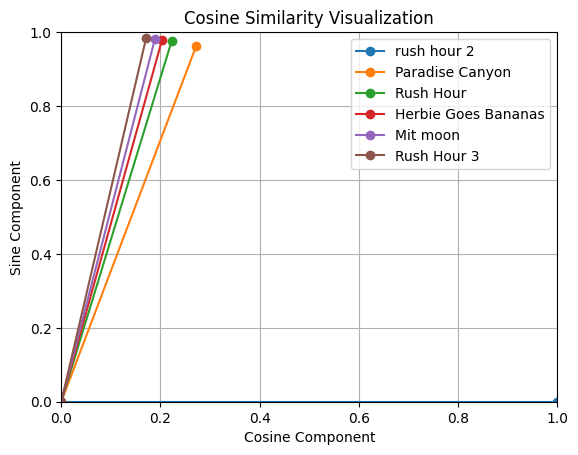

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# Combine relevant text features into a single string for vectorization
movies_df['combined_features'] = movies_df[['Tagline', 'Overview', 'Keywords_parse']].fillna('').agg(' '.join, axis=1)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Vectorize the combined features
tfidf_matrix = tfidf.fit_transform(movies_df['combined_features'])

# Initialize the Nearest Neighbors model
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5)

# Fit the model using the TF-IDF matrix
knn.fit(tfidf_matrix)

# Function to get top 5 movie recommendations with similarity scores
def get_movie_recommendations_with_similarity(movie_title, model=knn, matrix=tfidf_matrix, data=movies_df):
    idx = data.index[data['Original_Title'].str.lower() == movie_title.lower()].tolist()
    
    if len(idx) == 0:
        return "Movie not found in the database."
    
    idx = idx[0]
    
    distances, indices = model.kneighbors(matrix[idx], n_neighbors=6)
    
    similar_movies_indices = indices.flatten()[1:]
    similar_movies_distances = distances.flatten()[1:]
    
    similarity_scores = 1 - similar_movies_distances
    
    similar_movies = data.iloc[similar_movies_indices][['Original_Title']]
    similar_movies['Similarity_Score'] = similarity_scores
    
    return similar_movies

# Function to plot cosine similarity visualization
def plot_cosine_similarity(movie_title, recommendations_df):
    fig, ax = plt.subplots()

    base_similarity = 1.0
    movies = [movie_title] + recommendations_df['Original_Title'].tolist()
    similarities = [base_similarity] + recommendations_df['Similarity_Score'].tolist()

    # Convert similarity scores to angles for the plot (considering only the positive cosine similarities)
    angles = np.arccos(similarities)

    # Plot vectors for each movie, ensuring all vectors are in the positive quadrant
    for i, angle in enumerate(angles):
        x = np.cos(angle)
        y = np.sin(angle)
        ax.plot([0, x], [0, y], label=movies[i], marker='o')

    # Set axis limits to only show the positive quadrant (0 to 1)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Cosine Component')
    ax.set_ylabel('Sine Component')
    ax.axhline(0, color='grey', lw=0.5)
    ax.axvline(0, color='grey', lw=0.5)

    # Title and legend
    ax.set_title('Cosine Similarity Visualization')
    ax.legend()

    plt.grid(True)
    plt.show()

# Example usage
user_input_movie = input("Enter a movie title: ")

recommendations = get_movie_recommendations_with_similarity(user_input_movie)

if isinstance(recommendations, str):
    print(recommendations)
else:
    print(f"Movies similar to '{user_input_movie}':")
    print(recommendations)
    plot_cosine_similarity(user_input_movie, recommendations)
